In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
plt.rcParams.update({'font.size': 14})
import matplotlib.gridspec as gridspec

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [3]:
number=6
printnum=number
folder = "./Data example"
dt=0.18
pxtomum=0.027#0.0719e-6
offset = 28
dimx = 1001

R = 2.19e-6/2
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
D_0 = 3.85e-14

start_time = time.time()   
# File name of the original measurement data
if number < 10:
        tdms_file = TdmsFile(folder+"/Test_00"+str(number)+"_PN.tdms")
else:
    if number < 100:
        tdms_file = TdmsFile(folder+"/Test_0"+str(number)+"_PN.tdms")
    else:
        tdms_file = TdmsFile(folder+"/Test_"+str(number)+"_PN.tdms")
#images = loadTDMSImages(folder+"/Test_0"+str(number)+"_movie.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

videosize = dimx-1
Xc = tdms_file.channel_data('PN','Xc')
Yc = tdms_file.channel_data('PN','Yc')
phase = tdms_file.channel_data('PN','Delay')
#velocitytheo = tdms_file.channel_data('PN','Velocity')
#angletheo = tdms_file.channel_data('PN','Angle')
xolaser = tdms_file.channel_data('PN','Xh')
yolaser = tdms_file.channel_data('PN','Yh')
if videosize != 1000:
    xolaser -= (1000-videosize)/2
    yolaser -= (1000-videosize)/2
    Xc -= (1000-videosize)/2
    Yc -= (1000-videosize)/2
iterationtime = tdms_file.channel_data('PN','IterTime')
programtime = tdms_file.channel_data('PN','ProgTime')
Nfound = tdms_file.channel_data('PN','N')
maxlength = len(Nfound)
timewave=np.linspace(0,maxlength*dt,maxlength)

check = True; paths = 0; lengthpath = 0; count = 0; count2 = 0; lengthpath2 = 0
for i in range(maxlength):
    if(phase[i] == 0):
        if(check == True): 
            paths += 1
            check = False
        count += 1
    if(phase[i] == 2): 
        check = True
        if count > lengthpath: lengthpath = count
        count = 0
    if(phase[i] == 3):
        count2 += 1
    if(phase[i] == 5):
        if count2 > lengthpath2: lengthpath2 = count2
        count2 = 0
print('size of the video = ',videosize)
print('length of the movie = ',maxlength)
print('mean iteration time = ',round(mean(iterationtime),2),' ms')
print('mean program time = ',round(mean(programtime),2),' ms')
print('Trajectories = ',int(paths))
lengthpath += 1

--- 13.88 seconds ---
size of the video =  1000
length of the movie =  12053
mean iteration time =  182.17  ms
mean program time =  5.06  ms
Trajectories =  101


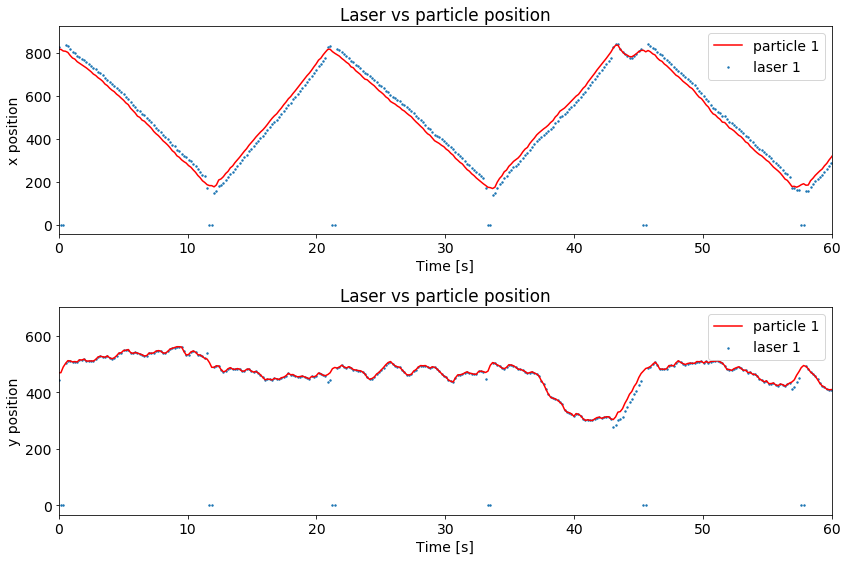

In [3]:
particles = np.zeros((maxlength,1,2))
xlaser = np.zeros((maxlength,1))
ylaser = np.zeros((maxlength,1))
count = 0; notone = 0; zerocount = 0
for i in range(maxlength):
    if Nfound[i] == 1:
        particles[i,0,0] = Xc[count]
        particles[i,0,1] = Yc[count]
        xlaser[i,0] = xolaser[count]
        ylaser[i,0] = yolaser[count]
        count += 1
    if Nfound[i] > 1:
        distshort = 100; jshort = 555
        for j in range(Nfound[i]):
            dist = np.sqrt(pow(particles[i-1,0,0]-Xc[count+j],2)+pow(particles[i-1,0,1]-Yc[count+j],2))
            if dist < distshort:
                jshort = j
                distshort = dist
        if jshort != 555:
            particles[i,0,0] = Xc[count+jshort]
            particles[i,0,1] = Yc[count+jshort]
            xlaser[i,0] = xolaser[count+jshort]
            ylaser[i,0] = yolaser[count+jshort]
        else:
            particles[i,0,0] = 0
        count += Nfound[i]
        notone += 1
        #print('i = ',i,' - found = ',Nfound[i])
    if Nfound[i] == 0:
        #print('i = ',i,' - found = 0')
        notone += 1
        zerocount += 1
    if particles[i,0,0] == videosize/2:
            particles[i,0,0] = 0
            zerocount += 1
for i in range(maxlength):
    if particles[i,0,0] == 0:
        prefound = False; pre = 0; postfound = False; post = 0
        while prefound == False:
            pre += 1
            if particles[i-pre,0,0] != 0:
                prefound = True
        while postfound == False:
            post += 1
            if i+post < maxlength:                
                if particles[i+post,0,0] != 0:
                    postfound = True
            else:
                postfound = True
                post = -pre
        factorpre = post/(pre+abs(post))
        factorpost = pre/(pre+abs(post))
        particles[i,0,0] = factorpre*particles[i-pre,0,0]+factorpost*particles[i+post,0,0]
        particles[i,0,1] = factorpre*particles[i-pre,0,1]+factorpost*particles[i+post,0,1]
        xlaser[i,0] = factorpre*xlaser[i-pre,0]+factorpost*xlaser[i+post,0]
        ylaser[i,0] = factorpre*ylaser[i-pre,0]+factorpost*ylaser[i+post,0]

fig=plt.figure(1, figsize = (12,8) )
plt.subplot(2,1,1)
plt.title('Laser vs particle position')
plt.xlabel('Time [s]')
plt.ylabel('x position')
plt.scatter(timewave,xlaser[:,0],label='laser 1', s=2)
plt.plot(timewave,particles[:,0,0],label='particle 1',color='r')
#plt.plot(timewave,angle,label='particle 1',color='r')
plt.xlim([0,60])
plt.legend()

plt.subplot(2,1,2)
plt.title('Laser vs particle position')
plt.xlabel('Time [s]')
plt.ylabel('y position')
plt.scatter(timewave,ylaser[:,0],label='laser 1', s=2)
plt.plot(timewave,particles[:,0,1],label='particle 1',color='r')
#plt.plot(timewave,angle,label='particle 1',color='r')
plt.xlim([0,60])
plt.legend()
plt.tight_layout()  
plt.show()
angle = np.zeros((maxlength,1))

np.savetxt('Dataxy'+str(printnum)+'.txt', np.transpose([particles[:,0,0],particles[:,0,1]]),fmt='%1.6f')
np.savetxt('DataLaserxy'+str(printnum)+'.txt', np.transpose([xlaser[:,0],ylaser[:,0]]),fmt='%1.6f')
np.savetxt('DataGeneral'+str(printnum)+'.txt', np.transpose([dt,pxtomum,offset,videosize]),fmt='%1.6f')
np.savetxt('DataIterationtime'+str(printnum)+'.txt', np.transpose([iterationtime]),fmt='%1.6f')
np.savetxt('DataProgramtime'+str(printnum)+'.txt', np.transpose([programtime]),fmt='%1.6f')

check=0
for i in range(maxlength):
    if particles[i,0,0] == 0:
        if check == 0:
            print('Still problems at')
            check = 1
        print('i = ',i)

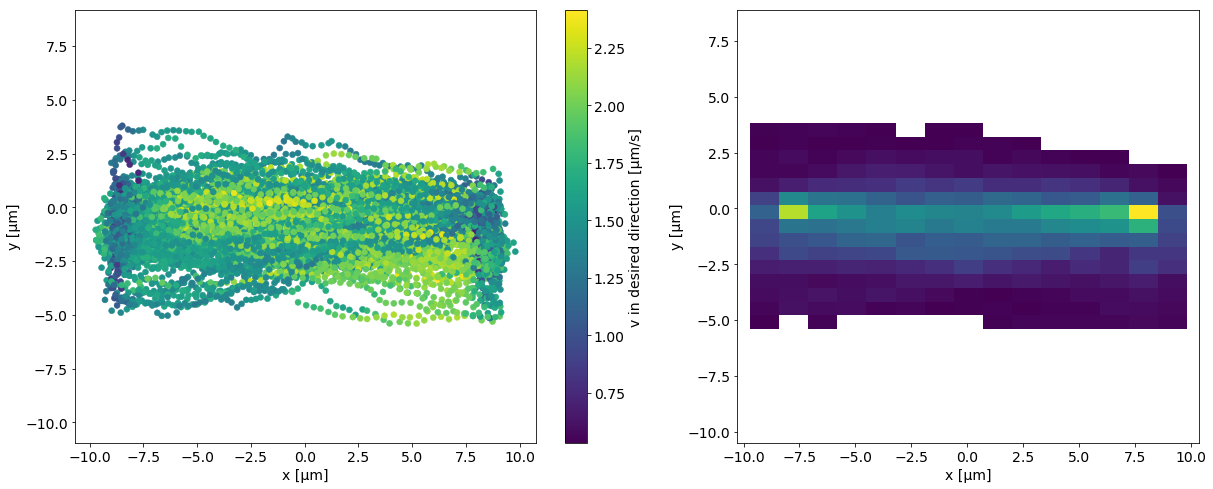

In [4]:
angle = np.zeros((maxlength,1))
for i in range(maxlength):
    if phase[i] == 3: angle[i] = 180

particlesdisplay=particles.copy()
particlesdisplay=(particlesdisplay-videosize/2)*pxtomum
directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros(maxlength)
velocitywithdiffusion=np.zeros(maxlength)
directionvector[:,0] = np.cos(angle[:,0]*np.pi/180)
directionvector[:,1] = np.sin(angle[:,0]*np.pi/180)
for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
    movingvector[i,0] = particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0]
    movingvector[i,1] = particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1]
    velocity[i] = abs(np.dot(directionvector[i,:], movingvector[i,:]))/dt
velocitywithdiffusion[:] = np.sqrt(pow(movingvector[:,0],2)+pow(movingvector[:,1],2))/dt 
distancetocenter=[]                                    #Calc velocity 
distancetocenter=np.sqrt(pow(particles[:,0,0]-videosize/2,2)+pow(particles[:,0,1]-videosize/2,2))
binwave=np.linspace(min(velocity),min(max(velocitywithdiffusion),5),20)

smoothvalue = 10
smoothit = smooth(velocity,smoothvalue)
x = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,0]
y = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,1]
v = smoothit[smoothvalue:maxlength-smoothvalue]
#x = particlesdisplay[:,0,0]
#y = particlesdisplay[:,0,1]
#v = velocity

x2 = particlesdisplay[:,0,0]
y2 = particlesdisplay[:,0,1]
factor = 1.1
xmin = factor*x.min()
xmax = factor*x.max()
ymin = factor*y.min()
ymax = factor*y.max()

fig, ax = plt.subplots(figsize=(17,7))        
gs = gridspec.GridSpec(1, 2, width_ratios=[1,0.8], height_ratios=[1])

ax1 = plt.subplot(gs[0])
im = ax1.scatter(x,y,c=v,linewidths=0.5)
ax1.set_xlabel('x [µm]')
ax1.set_ylabel('y [µm]')
ax1.axis('equal')
ax1.axis([xmin, xmax, ymin, ymax])
ax1.tick_params(axis='y')
cb = fig.colorbar(im, ax=ax1)
cb.set_label('v in desired direction [µm/s]')

ax2 = plt.subplot(gs[1])
hb = plt.hist2d(x2, y2, bins = 15, cmin = 1)
#hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
ax2.axis([xmin, xmax, ymin, ymax])
ax2.axis('equal')
ax2.set_xlabel('x [µm]')
ax2.set_ylabel('y [µm]')

plt.tight_layout() 
plt.savefig('Path of the particle colored'+str(printnum)+'.pdf', format='pdf')
plt.savefig('Path of the particle colored'+str(printnum)+'.svg', format='svg')
plt.show()

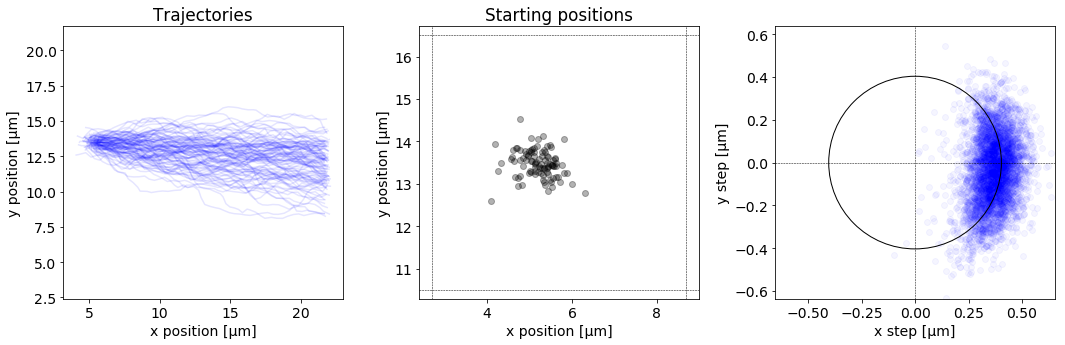

In [5]:
count = 0; count2 = 0
trajectories = np.zeros((lengthpath,int(paths+1),6))
countstepsr = np.zeros(int(paths+1))
for i in range(maxlength):
    if(phase[i] == 0):
        trajectories[count2,count,0] = particles[i,0,0]*pxtomum
        trajectories[count2,count,1] = particles[i,0,1]*pxtomum
        trajectories[count2,count,2] = xlaser[i,0]*pxtomum
        trajectories[count2,count,3] = ylaser[i,0]*pxtomum
        if i > 0:
            trajectories[count2,count,4] = trajectories[count2,count,0]-trajectories[count2-1,count,0]
            trajectories[count2,count,5] = trajectories[count2,count,1]-trajectories[count2-1,count,1]
            if trajectories[count2,count,4] > 1 or trajectories[count2,count,5] > 1: 
                trajectories[count2,count,4] = np.nan
                trajectories[count2,count,5] = np.nan
        trajectories[count2,count,4]
        count2 +=1
    if(phase[i] == 1 and phase[i-1] == 0):
        countstepsr[count] = count2
        count += 1
        count2 = 0
       
for i in range(int(paths+1)):
    for j in range(lengthpath):
        if trajectories[j,i,0] == 0:
            trajectories[j,i,:] = np.nan   
        if trajectories[j,i,4] > 2:
            trajectories[j,i,4] = np.nan  
            trajectories[j,i,5] = np.nan 
dl = np.sqrt(pow(trajectories[:,:,4],2)+pow(trajectories[:,:,5],2))

fig, ax = plt.subplots(figsize=(15, 5))
ax = plt.subplot(1,3,1)
for i in range(int(paths)):
    plt.plot(trajectories[:,i,0],trajectories[:,i,1],alpha = 0.1,color='b')
plt.title('Trajectories')
plt.xlabel('x position [µm]')
plt.ylabel('y position [µm]')
ax.axis('equal')

ax = plt.subplot(1,3,2)
for i in range(1,int(paths)):
    plt.scatter(trajectories[0,i,0],trajectories[0,i,1],color='k',alpha = 0.3)
plt.title('Starting positions')
ax.axis('equal')
plt.xlabel('x position [µm]')
plt.ylabel('y position [µm]')
plt.axhline(y=(500+111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')
plt.axhline(y=(500-111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=(211+111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=(211-111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')

ax = plt.subplot(1,3,3)
for i in range(int(paths)):
    plt.scatter(trajectories[1:,i,4],trajectories[1:,i,5],c='b',alpha = 0.04)
    #plt.plot(trajectories[:,i,4])
plt.xlabel('x step [µm]')
plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(dl) , color='k', fill=False)
ax.add_artist(circle2)
limit = np.nanmax(abs(trajectories[1:,:,4:]))
ax.axis('equal')
plt.xlim([-limit,limit])
plt.ylim([-limit,limit])
plt.title(' ')
plt.tight_layout()  
plt.savefig('Moveright'+str(printnum)+'.pdf', format='pdf')
plt.show()

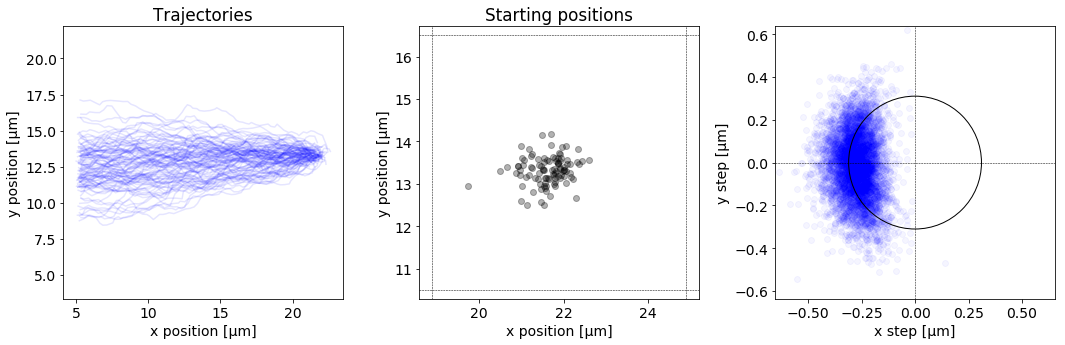

In [6]:
count = 0; count2 = 0
trajectories2 = np.zeros((lengthpath2,int(paths+2),6))
countstepsl = np.zeros(int(paths+2))
for i in range(maxlength):
    if(phase[i] == 3):
        trajectories2[count2,count,0] = particles[i,0,0]*pxtomum
        trajectories2[count2,count,1] = particles[i,0,1]*pxtomum
        trajectories2[count2,count,2] = xlaser[i,0]*pxtomum
        trajectories2[count2,count,3] = ylaser[i,0]*pxtomum
        if i > 0:
            trajectories2[count2,count,4] = trajectories2[count2,count,0]-trajectories2[count2-1,count,0]
            trajectories2[count2,count,5] = trajectories2[count2,count,1]-trajectories2[count2-1,count,1]
        trajectories2[count2,count,4]
        count2 +=1
    if(phase[i] == 1 and phase[i-1] == 0):
        countstepsl[count] = count2
        count += 1
        count2 = 0      
for i in range(int(paths+1)):
    for j in range(lengthpath2):
        if trajectories2[j,i,0] == 0:
            trajectories2[j,i,:] = np.nan   
        if trajectories2[j,i,4] > 2:
            trajectories2[j,i,4] = np.nan  
            trajectories2[j,i,5] = np.nan 
dl = np.sqrt(pow(trajectories2[:,:,4],2)+pow(trajectories2[:,:,5],2))

fig, ax = plt.subplots(figsize=(15, 5))
ax = plt.subplot(1,3,1)
for i in range(int(paths)):
    plt.plot(trajectories2[:,i,0],trajectories2[:,i,1],alpha = 0.1,color='b')
plt.title('Trajectories')
plt.xlabel('x position [µm]')
plt.ylabel('y position [µm]')
ax.axis('equal')

ax = plt.subplot(1,3,2)
for i in range(1,int(paths)):
    plt.scatter(trajectories2[0,i,0],trajectories2[0,i,1],color='k',alpha = 0.3)
plt.title('Starting positions')
ax.axis('equal')
plt.xlabel('x position [µm]')
plt.ylabel('y position [µm]')
plt.axhline(y=(500+111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')
plt.axhline(y=(500-111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=(811+111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=(811-111)*pxtomum,linewidth=0.5, color = 'k',linestyle='--')

ax = plt.subplot(1,3,3)
for i in range(int(paths)):
    plt.scatter(trajectories2[1:,i,4],trajectories2[1:,i,5],c='b',alpha = 0.04)
    #plt.plot(trajectories[:,i,4])
plt.xlabel('x step [µm]')
plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(dl) , color='k', fill=False)
ax.add_artist(circle2)
limit = np.nanmax(abs(trajectories[1:,:,4:]))
ax.axis('equal')
plt.xlim([-limit,limit])
plt.ylim([-limit,limit])
plt.tight_layout()  
plt.savefig('Moveleft'+str(printnum)+'.pdf', format='pdf')
plt.show()

correction angle right = -5.67
correction angle left = 3.24


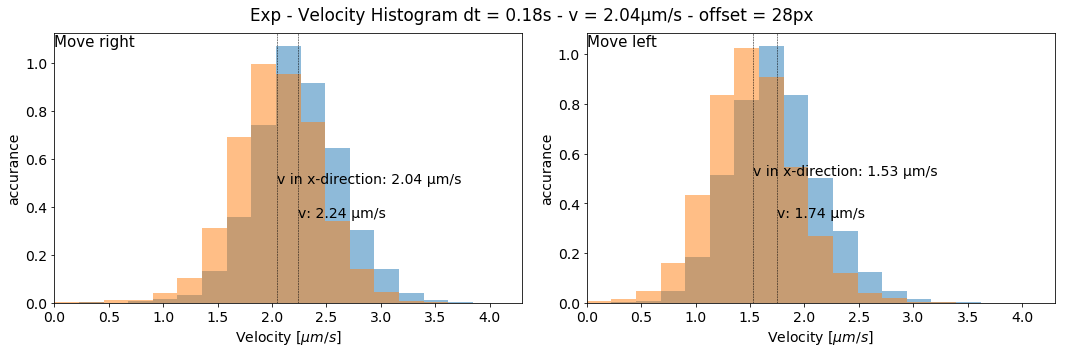

In [7]:
lengthstepsr = 0
for i in range(paths+1):
    for j in range(1,int(countstepsr[i])): lengthstepsr += 1
stepsr = np.zeros((lengthstepsr,5))
count = 0
for i in range(paths+1):
    for j in range(1,int(countstepsr[i])):
        stepsr[count,0] = trajectories[j,i,0] - trajectories[j-1,i,0]
        stepsr[count,1] = trajectories[j,i,1] - trajectories[j-1,i,1]
        if stepsr[count,0] > 1 or stepsr[count,1] > 1: 
            stepsr[count,0] = stepsr[count-1,0]
            stepsr[count,1] = stepsr[count-1,1]
        stepsr[count,2] = np.sqrt(pow(stepsr[count,0],2)+pow(stepsr[count,1],2))
        count += 1
radialparticle = np.zeros((lengthstepsr,2))
radialparticle[:,0] = stepsr[:,2]
for i in range(lengthstepsr):
    if stepsr[i,0] > 0: radialparticle[i,1] = np.arctan(stepsr[i,1]/stepsr[i,0])*180/np.pi
    else:
        if stepsr[i,1] < 0: radialparticle[i,1] = (np.arctan(stepsr[i,1]/stepsr[i,0])-np.pi)*180/np.pi
        else: radialparticle[i,1] = (np.arctan(stepsr[i,1]/stepsr[i,0])+np.pi)*180/np.pi
corrangleright = mean(radialparticle[1:,1])
print('correction angle right = '+str(round(corrangleright,2)))
radialparticle[:,1] -= corrangleright
stepsr[:,3] = radialparticle[:,0]*np.cos(radialparticle[:,1]*np.pi/180)
stepsr[:,4] = radialparticle[:,0]*np.sin(radialparticle[:,1]*np.pi/180)

lengthstepsl = 0
for i in range(paths+1):
    for j in range(1,int(countstepsl[i])): lengthstepsl += 1
stepsl = np.zeros((lengthstepsl,5))
count = 0
for i in range(paths+1):
    for j in range(1,int(countstepsl[i])):
        stepsl[count,0] = trajectories2[j,i,0] - trajectories2[j-1,i,0]
        stepsl[count,1] = trajectories2[j,i,1] - trajectories2[j-1,i,1]
        stepsl[count,2] = np.sqrt(pow(stepsl[count,0],2)+pow(stepsl[count,1],2))
        count += 1
radialparticle2 = np.zeros((lengthstepsl,2))
radialparticle2[:,0] = stepsl[:,2]
for i in range(lengthstepsl):
    if stepsl[i,0] < 0: radialparticle2[i,1] = np.arctan(stepsl[i,1]/stepsl[i,0])*180/np.pi
    else:
        if stepsl[i,1] < 0: radialparticle2[i,1] = (np.arctan(stepsl[i,1]/stepsl[i,0])+np.pi)*180/np.pi
        else: radialparticle2[i,1] = (np.arctan(stepsl[i,1]/stepsl[i,0])-np.pi)*180/np.pi
corrangleleft = mean(radialparticle2[1:,1])
print('correction angle left = '+str(round(corrangleleft,2)))
radialparticle2[:,1] -= corrangleleft
stepsl[:,3] = radialparticle2[:,0]*np.cos((radialparticle2[:,1]+180)*np.pi/180)
stepsl[:,4] = radialparticle2[:,0]*np.sin((radialparticle2[:,1]+180)*np.pi/180)

#maxr = min(4,max(stepsr[1:,2]/dt)); maxl = min(4,max(stepsl[1:,2]/dt))
maxr = np.nanmax(stepsr[1:,2]/dt); maxl = np.nanmax(stepsl[1:,2]/dt)
binwave = np.linspace(0,max(maxr,maxl),20)
vright = np.mean(stepsr[1:,2])/dt
vrightx = np.mean(stepsr[1:,3])/dt
vleft = np.mean(stepsl[1:,2]/dt)
vleftx = -np.mean(stepsl[1:,3]/dt)
varrightx = var(stepsr[1:,3])
varrighty = var(stepsr[1:,4])
stdrightangle = std(radialparticle[1:,1])
varleftx = var(stepsl[1:,3])
varlefty = var(stepsl[1:,4])
stdleftangle = std(radialparticle2[1:,1])

fig=plt.figure(1, figsize = (15,5) )
plt.subplot(1,2,1)
data = plt.hist(stepsr[1:,2]/dt, bins=binwave,alpha = 0.5,normed=1,label='v')
data2 = plt.hist(stepsr[1:,3]/dt, bins=binwave,alpha = 0.5,normed=1,label='v in x-direction')
plt.axvline(x=vright,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=vrightx,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
plt.xlim([0,min(max(maxr,maxl),5)])
plt.text(vright,max(data[0])/3,'v: {:.2f} µm/s'.format(round(np.mean(stepsr[1:,2])/dt,2)))
plt.text(vrightx,max(data2[0])/2,'v in x-direction: {:.2f} µm/s'.format(round(np.mean(stepsr[1:,3])/dt,2)))
plt.title(' ')
plt.text(0,max(data[0]),'Move right',fontsize=15)

plt.subplot(1,2,2)
data = plt.hist(stepsl[1:,2]/dt, bins=binwave,alpha = 0.5,normed=1,label='v')
data2 = plt.hist(-stepsl[1:,3]/dt, bins=binwave,alpha = 0.5,normed=1,label='v in x-direction')
plt.axvline(x=vleft,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=vleftx,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
plt.xlim([0,min(max(maxr,maxl),5)])
plt.text(vleft,max(data[0])/3,'v: {:.2f} µm/s'.format(round(np.mean(stepsl[1:,2])/dt,2)))
plt.text(vleftx,max(data2[0])/2,'v in x-direction: {:.2f} µm/s'.format(round(-np.mean(stepsl[1:,3])/dt,2)))
plt.title(' ')
plt.text(0,max(data[0]),'Move left',fontsize=15)
fig.suptitle('Exp - Velocity Histogram dt = '+str(dt)+'s - v = '+str(round(vrightx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout()  
plt.savefig('Exp - Velocity Histogram dt '+str(dt)+'s - v '+str(round(vrightx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show() 

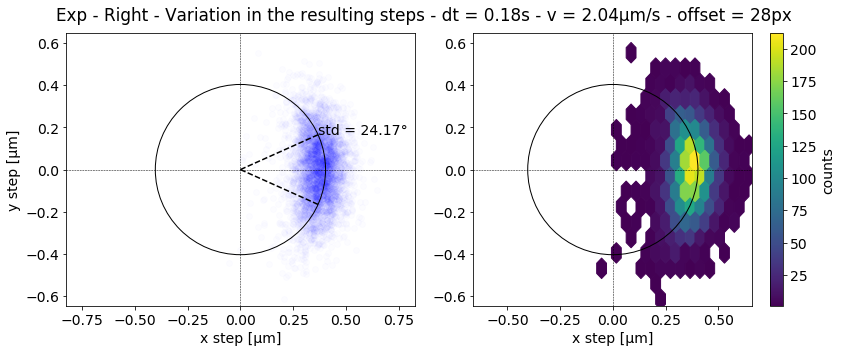

In [8]:
fig, ax = plt.subplots(figsize=(12, 5), sharey='all')
ax = plt.subplot(1,2,1)
plt.scatter(stepsr[:,3],stepsr[:,4],c='b',alpha = 0.01)
plt.xlabel('x step [µm]')
plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(stepsr[:,2]) , color='k', fill=False)
ax.add_artist(circle2)
limit = np.nanmax(abs(stepsr[:,3:4]))
ax.axis('equal')
ax.set_xlim([-limit,limit])
ax.set_ylim([-limit,limit])
plt.title(' ')
x = np.cos(stdrightangle*np.pi/180)*np.nanmean(stepsr[:,2])
y = np.sin(stdrightangle*np.pi/180)*np.nanmean(stepsr[:,2])
plt.plot([0,x],[0,y],'k--')
plt.plot([0,x],[0,-y],'k--')
plt.text(x,y,'std = '+str(round(stdrightangle,2))+'°')

gridsizevalue = 15
ax2 = plt.subplot(1,2,2)
hb = ax2.hexbin(stepsr[:,3],stepsr[:,4], gridsize=gridsizevalue,mincnt=0.01)
cb = fig.colorbar(hb, ax=ax2)
cb.set_label('counts')
plt.xlabel('x step [µm]')
#plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(stepsr[:,2]) , color='k', fill=False)
ax2.add_artist(circle2)
ax2.axis('equal')
ax2.set_xlim([-limit,limit])
ax2.set_ylim([-limit,limit])
plt.title(' ')

fig.suptitle('Exp - Right - Variation in the resulting steps - dt = '+str(dt)+'s - v = '+str(round(vrightx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout()  
plt.savefig('Exp - Right - Resulting steps dt '+str(dt)+'s - v '+str(round(vrightx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

In [20]:
len(stepsr)

4537

/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: in

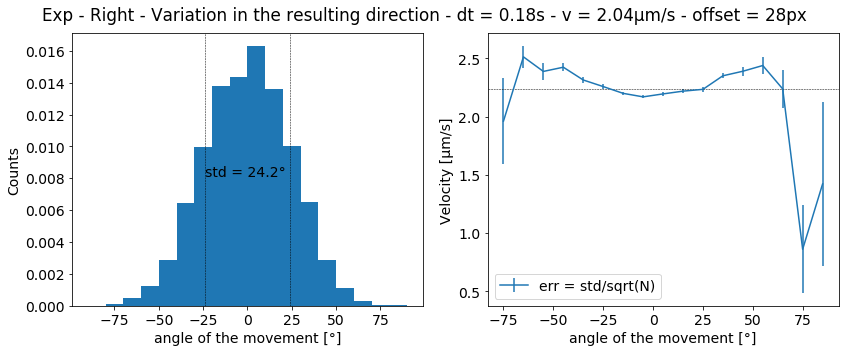

In [9]:
anglewave = np.linspace(-90,90,19)
collectv = np.zeros((lengthstepsr,19))
count = np.zeros(19)
for i in range(2,lengthstepsr):
    j = 1; check = False
    while check == False:
        if radialparticle[i,1] < anglewave[j] and radialparticle[i,1] > anglewave[j-1]:
            collectv[int(count[j]),j] = radialparticle[i,0]
            count[j] += 1
            check = True
        else: j += 1
        if j == 19:
            check = True
            
averagev = np.zeros((19,2))
for i in range(1,19):
    averagev[i,0] = mean(collectv[:int(count[i]),i])
    averagev[i,1] = std(collectv[:int(count[i]),i])
averagev[:,1] /= np.sqrt(count[:])
    
anglewave2 = np.zeros(18)
for i in range(18):
    anglewave2[i] = (anglewave[i]+anglewave[i+1])/2
    
fig, ax = plt.subplots(figsize=(12, 5), sharey='all')
ax = plt.subplot(1,2,1)
binwave = np.linspace(-90,90,19)
data = plt.hist(radialparticle[1:,1],bins=binwave,normed=1)
plt.axvline(x=stdrightangle,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=-stdrightangle,linewidth=0.5, color = 'k',linestyle='--')
plt.text(-stdrightangle,max(data[0])/2,'std = '+str(round(stdrightangle,1))+'°')
plt.xlabel('angle of the movement [°]')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
plt.errorbar(anglewave2,averagev[1:,0]/dt,yerr= averagev[1:,1]/dt,label='err = std/sqrt(N)')
plt.axhline(y=vright,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('angle of the movement [°]')
plt.ylabel('Velocity [µm/s]')
plt.title(' ')
plt.legend()

fig.suptitle('Exp - Right - Variation in the resulting direction - dt = '+str(dt)+'s - v = '+str(round(vrightx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout()  
plt.savefig('Exp - Right - Velocity vs Direction dt '+str(dt)+'s - v '+str(round(vrightx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

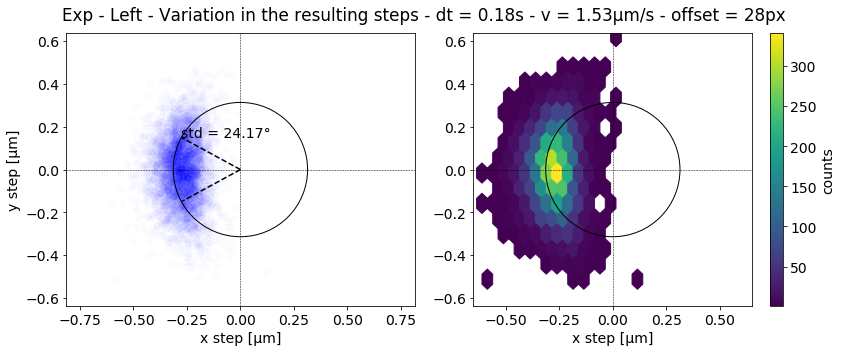

In [10]:
fig, ax = plt.subplots(figsize=(12, 5), sharey='all')
ax = plt.subplot(1,2,1)
plt.scatter(stepsl[:,3],stepsl[:,4],c='b',alpha = 0.01)
plt.xlabel('x step [µm]')
plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(stepsl[:,2]) , color='k', fill=False)
ax.add_artist(circle2)
limit = np.nanmax(abs(stepsl[:,3:4]))
ax.axis('equal')
ax.set_xlim([-limit,limit])
ax.set_ylim([-limit,limit])
plt.title(' ')
x = -np.cos(stdleftangle*np.pi/180)*np.nanmean(stepsl[:,2])
y = np.sin(stdleftangle*np.pi/180)*np.nanmean(stepsl[:,2])
plt.plot([0,x],[0,y],'k--')
plt.plot([0,x],[0,-y],'k--')
plt.text(x,y,'std = '+str(round(stdrightangle,2))+'°')

gridsizevalue = 15
ax2 = plt.subplot(1,2,2)
hb = ax2.hexbin(stepsl[:,3],stepsl[:,4], gridsize=gridsizevalue,mincnt=0.01)
cb = fig.colorbar(hb, ax=ax2)
cb.set_label('counts')
plt.xlabel('x step [µm]')
#plt.ylabel('y step [µm]')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=0,linewidth=0.5, color = 'k',linestyle='--')
circle2 = plt.Circle((0, 0), np.nanmean(stepsl[:,2]) , color='k', fill=False)
ax2.add_artist(circle2)
ax2.axis('equal')
ax2.set_xlim([-limit,limit])
ax2.set_ylim([-limit,limit])
plt.title(' ')

fig.suptitle('Exp - Left - Variation in the resulting steps - dt = '+str(dt)+'s - v = '+str(round(vleftx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout()  
plt.savefig('Exp - Left - Resulting steps dt '+str(dt)+'s - v '+str(round(vleftx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


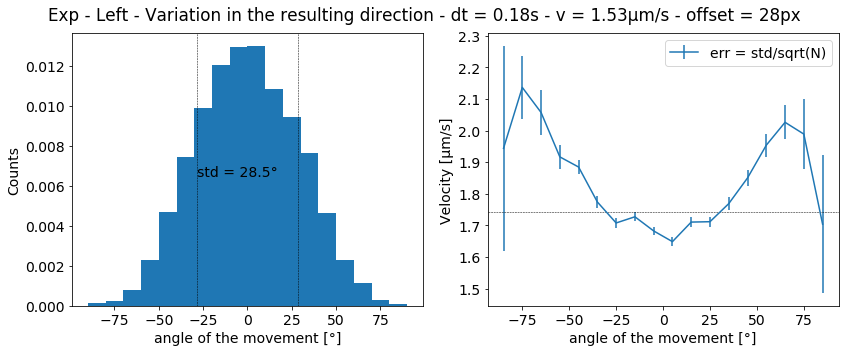

In [11]:
anglewave = np.linspace(-90,90,19)
collectv = np.zeros((lengthstepsl,19))
count = np.zeros(19)
for i in range(2,lengthstepsl):
    j = 1; check = False
    while check == False:
        if radialparticle2[i,1] < anglewave[j] and radialparticle2[i,1] > anglewave[j-1]:
            collectv[int(count[j]),j] = radialparticle2[i,0]
            count[j] += 1
            check = True
        else: j += 1
        if j == 19:
            check = True
            
averagev = np.zeros((19,2))
for i in range(1,19):
    averagev[i,0] = mean(collectv[:int(count[i]),i])
    averagev[i,1] = std(collectv[:int(count[i]),i])
averagev[:,1] /= np.sqrt(count[:])
    
anglewave2 = np.zeros(18)
for i in range(18):
    anglewave2[i] = (anglewave[i]+anglewave[i+1])/2
    
fig, ax = plt.subplots(figsize=(12, 5), sharey='all')
ax = plt.subplot(1,2,1)
binwave = np.linspace(-90,90,19)
data = plt.hist(radialparticle2[1:,1],bins=binwave,normed=1)
plt.axvline(x=stdleftangle,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=-stdleftangle,linewidth=0.5, color = 'k',linestyle='--')
plt.text(-stdleftangle,max(data[0])/2,'std = '+str(round(stdleftangle,1))+'°')
plt.xlabel('angle of the movement [°]')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
plt.errorbar(anglewave2,averagev[1:,0]/dt,yerr= averagev[1:,1]/dt,label='err = std/sqrt(N)')
plt.axhline(y=vleft,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('angle of the movement [°]')
plt.ylabel('Velocity [µm/s]')
plt.title(' ')
plt.legend()

fig.suptitle('Exp - Left - Variation in the resulting direction - dt = '+str(dt)+'s - v = '+str(round(vleftx,2))+'µm/s - offset = '+str(offset)+'px')
plt.tight_layout()  
plt.savefig('Exp - Left - Velocity vs Direction dt '+str(dt)+'s - v '+str(round(vleftx,2))+'ums - offset '+str(offset)+'px.pdf', format='pdf')
plt.show()

np.savetxt('DataExp-file'+str(number)+'.txt', np.transpose([vright,vrightx,vleft,vleftx,corrangleright,corrangleleft,stdrightangle,varrightx,varrighty,stdleftangle,varleftx,varlefty]),fmt='%1.6f')